In [55]:
import os, re, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

RANDOM_STATE = 42
DATA_PATH = "flight_price_eda.csv"


In [ ]:
#find the target variable automatically:

df=pd.read_csv(DATA_PATH)
print("Loaded data with shape:",df.shape)
#find the candidate that may be target variable:
candidates=[c for c in df.columns if re.search('price|fare|cost|amount',c,re.I)] # regex to match price related columns]
if candidates:
    target=candidates[0]
else:
    num_cols=df.select_dtypes(include=[np.number]).columns # numerical columns
    target=df[num_cols].var().idxmax() # column with highest variance
print("Selected target variable:",target)
print(df[target].describe())

Loaded data with shape: (10683, 42)
Selected target variable: Price
count    10683.000000
mean      9087.064121
std       4611.359167
min       1759.000000
25%       5277.000000
50%       8372.000000
75%      12373.000000
max      79512.000000
Name: Price, dtype: float64



Missing values in each column:
Total_Stops         0
Price               0
Date                0
Month               0
Arrival_Hour        0
Arrival_Minute      0
Dep_Hour            0
Dep_Minute          0
Duration_Min        0
Airline_Air Asia    0
dtype: int64


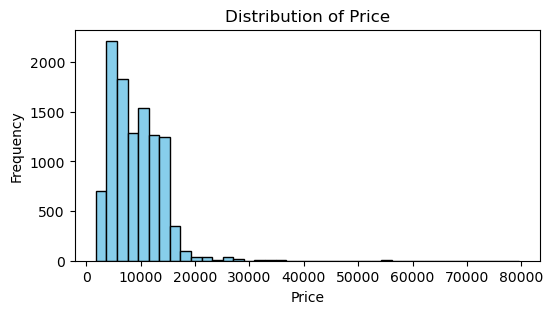

In [4]:
#verify that the dataset is clean and quick EDA:
print("\nMissing values in each column:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

plt.figure(figsize=(6,3))
plt.hist(df[target].dropna(),bins=40,color='skyblue',edgecolor='black')
plt.title(f"Distribution of {target}")
plt.xlabel(target)
plt.ylabel("Frequency")
plt.show()

In [9]:
skewness=df[target].skew()
kurtosis=df[target].kurtosis()
print(f"\nSkewness of {target}: {skewness:.2f}")
print(f"Kurtosis of {target}: {kurtosis:.2f}")

def skewness_kurtosis(target,df2):
    skewness=df2[target].skew()
    kurtosis=df2[target].kurtosis()
    print(f"\nSkewness of {target}: {skewness:.2f}")
    print(f"Kurtosis of {target}: {kurtosis:.2f}")
    


Skewness of Price: 1.81
Kurtosis of Price: 13.30


- Since skewness and kurtosis is high we need to apply log/sqrt transform to the target variable data to get appropriate values as regression models will not be effective without it

In [6]:
df2=df.copy()

In [15]:
df2['Price_log']=np.log1p(df2[target]) # log(1+x) to handle zero values if any 
df2['Price_sqrt']=np.sqrt(df2[target])
# df2['Price_boxcox'],lam=scipy.stats.boxcox(df2[target]+1) # boxcox requires positive values
skewness_kurtosis('Price_log',df2)
skewness_kurtosis('Price_sqrt',df2)


Skewness of Price_log: -0.25
Kurtosis of Price_log: -0.40

Skewness of Price_sqrt: 0.43
Kurtosis of Price_sqrt: 0.96


- since we get a nearly zero value for both skewness and kurtosis af square root transformation so that is the appropriate transformation choice and so we will use that as our target variable.

In [40]:
new_df=df.copy()
new_df['sqrt_price']=np.sqrt(new_df[target])
print(new_df['sqrt_price'].skew())
print(new_df['sqrt_price'].kurtosis())
new_df.info()

0.431746548777972
0.9628075962660083
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 43 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Total_Stops                                   10683 non-null  int64  
 1   Price                                         10683 non-null  int64  
 2   Date                                          10683 non-null  int64  
 3   Month                                         10683 non-null  int64  
 4   Arrival_Hour                                  10683 non-null  int64  
 5   Arrival_Minute                                10683 non-null  int64  
 6   Dep_Hour                                      10683 non-null  int64  
 7   Dep_Minute                                    10683 non-null  int64  
 8   Duration_Min                                  10683 non-null  int64  
 9   Airline_Air Asia        

In [50]:
#Train/Test split(80/20)
# Features (no change)
X = new_df.drop(columns=['Price', 'sqrt_price'])  # drop original Price to avoid leakage in features if present
y_raw = new_df['Price']  # target variable 

# Train/test split (80/20) - keep same random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y_raw, test_size=0.22, random_state=RANDOM_STATE, shuffle=True)



print("Train shape:",X_train.shape)
print("Test shape:",X_test.shape)
print("Train target mean:",y_train.mean())
print("Test target mean:",y_test.mean())
#y_train.mean() vs y_test.mean() — they should be similar. 
# Large differences may indicate leakage or non-random ordering in the CSV (e.g., sorted by date).

Train shape: (8332, 41)
Test shape: (2351, 41)
Train target mean: 9084.401344215074
Test target mean: 9096.501063377285


**Preprocessing pipeline**

- Purpose: Build a ColumnTransformer so preprocessing is fitted only on training data and applied identically at predict time — avoids leakage.

In [51]:
numeric_cols=X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols=X.select_dtypes(include=['object','category','bool']).columns.tolist()
num_pipe=Pipeline([("imputer",SimpleImputer(strategy='median')),("scaler",StandardScaler())])
transformers = [("num",num_pipe,numeric_cols)]
if cat_cols:
    cat_pipe=Pipeline([("imputer",SimpleImputer(strategy='most_frequent')),("onehot",OneHotEncoder(handle_unknown='ignore',sparse_output=False))])
    transformers.append(("cat",cat_pipe,cat_cols))

preprocessor=ColumnTransformer(transformers=transformers,remainder='drop')

**Explanation**

- numeric_cols: automatically detect numeric features (integers/floats).

- cat_cols: detect object/categorical features (strings, booleans).

- num_pipe: impute missing values with median (robust to outliers) then standardize (zero mean, unit variance).

- cat_pipe: most frequent fill then one-hot encode. handle_unknown="ignore" prevents errors with unseen categories at test time.

- remainder="drop": drop columns not listed (shouldn’t happen if we collected all).

**Why in a pipeline?**

Ensures fit() is called on training data only (imputer and scaler learn from train), then transform() is applied to test/new data. This prevents data leakage.

In [52]:
from sklearn.compose import TransformedTargetRegressor

In [67]:
reg_pipeline = Pipeline([("preproc", preprocessor), ("model", LinearRegression())])

ttr = TransformedTargetRegressor(regressor=reg_pipeline, func=np.sqrt, inverse_func=np.square)

# Cross-validated baseline on TRAIN (in transformed space)
cv_scores = cross_val_score(ttr, X_train, y_train, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(-cv_scores)

print("CV RMSE (original Price units):", np.round(cv_rmse, 3), "mean:", np.round(cv_rmse.mean(),3))

# Fit, predict (predictions are in sqrt-space)
ttr.fit(X_train, y_train)
y_pred = ttr.predict(X_test)

# Invert transform to get predictions back to original price scale
#y_pred_original_from_reg = np.square(y_pred_sqrt)

# Evaluate on original price units
#reg_rmse  = root_mean_squared_error(y_test_original, y_pred_original_from_reg, squared=False)
print("TEST RMSE:", root_mean_squared_error(y_test, y_pred))
print("TEST MAE:", mean_absolute_error(y_test, y_pred))
print("TEST R2:", r2_score(y_test, y_pred))

CV RMSE (original Price units): [2374.411 2803.05  2702.299] mean: 2626.587
TEST RMSE: 2577.442518594884
TEST MAE: 1736.8755860594674
TEST R2: 0.6835767531066108


In [86]:
#save the model
joblib.dump(ttr, "lr_model.pkl",compress=3)

['lr_model.pkl']

In [78]:
from sklearn.metrics import accuracy_score

In [87]:
loaded_model = joblib.load("lr_model.pkl")
pred=loaded_model.predict(X_test)
print(pred)
X_test

[ 9018.88267207  7217.13800275 13752.8049147  ... 10797.40141394
 10178.13397701 13730.51270901]


,Total_Stops,Date,Month,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute,Duration_Min,Airline_Air Asia,Airline_Air India,...,Additional_Info_1 Long layover,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight
6076,1,18,5,18,15,5,45,750,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3544,1,3,6,19,35,10,35,540,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7313,1,1,5,19,50,14,5,345,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5032,0,24,5,17,5,14,45,140,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2483,1,21,5,4,25,22,50,335,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5768,1,9,5,19,0,8,45,615,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3334,1,27,5,19,15,7,0,735,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
934,1,21,3,20,20,8,0,740,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4771,1,3,3,7,40,19,0,760,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# buildng a tree based model for better performance:

In [82]:
#build a random forest model and compare the results
rf_pipeline = Pipeline([("preproc", preprocessor), ("model", RandomForestRegressor(random_state=RANDOM_STATE,n_jobs=-1))])

cv=5
cv_scores_rf = cross_val_score(rf_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_rf = np.sqrt(-cv_scores_rf)
print("RF CV RMSE (original Price units):", np.round(cv_rmse_rf, 3), "mean:", np.round(cv_rmse_rf.mean(),3))

#fit default RF model and evaluate on test set
start=time.time()
rf_pipeline.set_params(model__n_estimators=200, model__max_depth=None)
rf_pipeline.fit(X_train, y_train)
fit_time=time.time()-start
print(f"RF fit time for {rf_pipeline['model'].n_estimators} trees: {fit_time:.2f} seconds")

#evaluate on test set
y_pred_rf = rf_pipeline.predict(X_test)
print("RF TEST RMSE:", root_mean_squared_error(y_test, y_pred_rf))
print("RF TEST MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RF TEST R2:", r2_score(y_test, y_pred_rf))


RF CV RMSE (original Price units): [1267.717 1681.953 1829.972 1776.029 1448.74 ] mean: 1600.882
RF fit time for 200 trees: 0.96 seconds
RF TEST RMSE: 1527.1392660161314
RF TEST MAE: 648.3428059792186
RF TEST R2: 0.8889169761513309


In [ ]:
 #Hyperparameter search (RandomizedSearchCV)
param_dist = {
    "model__n_estimators": [100, 200, 400, 700],
    "model__max_depth": [None, 10, 20, 30, 40],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5]
}

rs = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_mean_squared_error",
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

print("Starting RandomizedSearchCV (this may take a while) ...")
t0 = time.time()
rs.fit(X_train, y_train)
rs_time = time.time() - t0
print("RandomizedSearchCV done in {:.1f}s".format(rs_time))
print("Best params:", rs.best_params_)

best_model = rs.best_estimator_

# ) Evaluate best model on test
y_pred_best = best_model.predict(X_test)
best_rmse = root_mean_squared_error(y_test, y_pred_best)
best_mae = mean_absolute_error(y_test, y_pred_best)
best_r2 = r2_score(y_test, y_pred_best)
print("Best RF (test) RMSE:", round(best_rmse,2), "MAE:", round(best_mae,2), "R2:", round(best_r2,4))


Starting RandomizedSearchCV (this may take a while) ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomizedSearchCV done in 34.8s
Best params: {'model__n_estimators': 700, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': 0.5, 'model__max_depth': 40}
Best RF (test) RMSE: 1485.15 MAE: 738.45 R2: 0.8949


In [88]:
import time
import json

In [89]:
# save the best model
joblib.dump(best_model, 'rf_model.pkl', compress=3)
meta = {
    "model_path": 'rf_meta.json',
    "best_params": rs.best_params_,
    "metrics_test": {"rmse": float(best_rmse), "mae": float(best_mae), "r2": float(best_r2)},
    "train_rows": int(X_train.shape[0]),
    "test_rows": int(X_test.shape[0]),
    "fit_time_sec": rs_time,
    "numeric_cols": numeric_cols,
    "cat_cols": cat_cols
}
with open('rf_meta.json', "w") as f:
    json.dump(meta, f, indent=2)

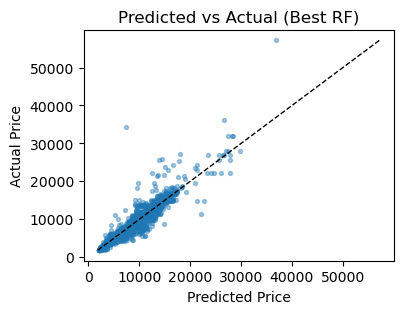

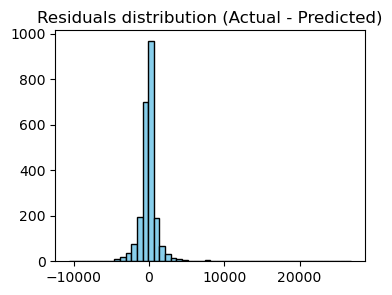

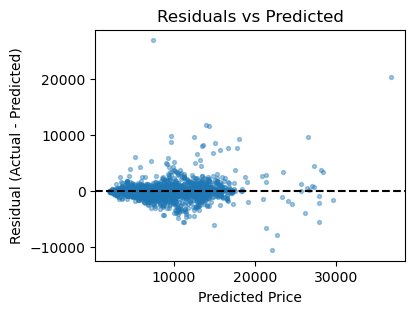

Top 10 worst errors:
      actual          pred     abs_error
1006   34273   7427.946368  26845.053632
967    57209  36840.132550  20368.867450
373    25703  13937.792729  11765.207271
2217   25913  14372.432178  11540.567822
2224   11507  22071.113894  10564.113894
1984   19508   9684.922579   9823.077421
704    36235  26600.808979   9634.191021
48     22153  12519.268624   9633.731376
207    27210  17990.520964   9219.479036
807    18308   9597.550873   8710.449127


In [95]:
#Diagnostics: residuals, predicted vs actual, largest errors ----------
residuals = y_test.values - y_pred_best
# Predicted vs Actual scatter
# Residual histogram and residual vs predicted
import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
plt.scatter(y_pred_best, y_test, alpha=0.4, s=8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="k", linewidth=1, linestyle="--")
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title("Predicted vs Actual (Best RF)")
plt.show()

plt.figure(figsize=(4,3))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title("Residuals distribution (Actual - Predicted)")
plt.show()

plt.figure(figsize=(4,3))
plt.scatter(y_pred_best, residuals, alpha=0.4, s=8)
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.show()

# Top 10 worst predictions (absolute error)
error_df = pd.DataFrame({
    "actual": y_test.values,
    "pred": y_pred_best,
    "abs_error": np.abs(y_test.values - y_pred_best)
})
worst10 = error_df.sort_values("abs_error", ascending=False).head(10)
print("Top 10 worst errors:")
print(worst10)


# creating a xgboost based model for better accuracy

In [100]:
from xgboost import XGBRegressor

In [102]:
#baseline XGBoost model
xgb_baseline= XGBRegressor(
    objective="reg:squarederror",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_estimators=200,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    learning_rate=0.1,
    verbosity=0
)

xgb_pipeline = Pipeline([("preproc", preprocessor), ("model", xgb_baseline)])

#quick cross-validated RMSE on train set 5-fold
cv_scores_xgb = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_xgb = np.sqrt(-cv_scores_xgb)
print("XGB CV RMSE (original Price units):", np.round(cv_rmse_xgb, 3), "mean:", np.round(cv_rmse_xgb.mean(),3))

#fit and evaluate on test set
start=time.time()
xgb_pipeline.fit(X_train, y_train)
fit_time=time.time()-start
print(f"XGB fit time for {xgb_pipeline['model'].n_estimators} trees: {fit_time:.2f} seconds")

#evaluate on test set
y_pred_xgb = xgb_pipeline.predict(X_test)
print("XGB TEST RMSE:", root_mean_squared_error(y_test, y_pred_xgb))
print("XGB TEST MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("XGB TEST R2:", r2_score(y_test, y_pred_xgb))

XGB CV RMSE (original Price units): [1312.975 1443.065 1745.43  1777.984 1421.808] mean: 1540.253
XGB fit time for 200 trees: 0.25 seconds
XGB TEST RMSE: 1454.9737548828125
XGB TEST MAE: 822.974609375
XGB TEST R2: 0.8991674780845642


- hyperparameter tuning

In [103]:
param_dist = {
    "model__n_estimators": [100, 200, 400, 700],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__max_depth": [3, 5, 6, 8, 10],
    "model__subsample": [0.6, 0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.5, 0.7, 0.8, 1.0],
    "model__reg_alpha": [0, 0.1, 0.5, 1.0],
    "model__reg_lambda": [0.5, 1.0, 2.0, 5.0]
}

rs = RandomizedSearchCV(
    estimator = xgb_pipeline,
    param_distributions = param_dist,
    n_iter = 24,               # number of random configurations to try
    scoring = "neg_mean_squared_error",
    cv = 5,
    random_state = RANDOM_STATE,
    n_jobs = -1,
    verbose = 2
)

print("Starting RandomizedSearchCV for XGBoost (this may take several minutes)...")
t0 = time.time()
rs.fit(X_train, y_train)
print("Search took {:.1f}s".format(time.time() - t0))
print("Best params:", rs.best_params_)

best_xgb = rs.best_estimator_

# Evaluate best model on test
y_pred_best = best_xgb.predict(X_test)
best_rmse = root_mean_squared_error(y_test, y_pred_best)
best_mae = mean_absolute_error(y_test, y_pred_best)
best_r2 = r2_score(y_test, y_pred_best)
print("Best XGB (test) RMSE:", round(best_rmse,2), "MAE:", round(best_mae,2), "R2:", round(best_r2,4))


Starting RandomizedSearchCV for XGBoost (this may take several minutes)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Search took 19.5s
Best params: {'model__subsample': 0.8, 'model__reg_lambda': 5.0, 'model__reg_alpha': 1.0, 'model__n_estimators': 700, 'model__max_depth': 8, 'model__learning_rate': 0.05, 'model__colsample_bytree': 1.0}
Best XGB (test) RMSE: 1350.46 MAE: 655.59 R2: 0.9131


In [112]:
#Diagnostics: residuals, predicted vs actual, largest errors ----------
residuals = y_test.values - y_pred_best

# Top 10 worst predictions (absolute error)
error_df = pd.DataFrame({
    "actual": y_test.values,
    "pred": y_pred_best,
    "abs_error": np.abs(y_test.values - y_pred_best)
})
worst10 = error_df.sort_values("abs_error", ascending=True).head(10)
print("Top 10 worst errors:")
print(worst10)


Top 10 worst errors:
      actual          pred  abs_error
487    11087  11086.668945   0.331055
1675    3841   3841.905029   0.905029
320     4804   4803.013672   0.986328
1183    3100   3098.665039   1.334961
945    11087  11089.254883   2.254883
2249    3898   3900.375732   2.375732
2181    5228   5225.603027   2.396973
1422    4591   4587.915527   3.084473
325    12373  12369.829102   3.170898
1949   12373  12369.731445   3.268555


Top 20 XGBoost importances:


Airline_Jet Airways Business                   0.370043
Airline_Jet Airways                            0.120574
Source_Banglore                                0.081174
Duration_Min                                   0.068445
Additional_Info_In-flight meal not included    0.057179
Airline_Multiple carriers                      0.030778
Destination_New Delhi                          0.023450
Additional_Info_Business class                 0.022681
Total_Stops                                    0.021195
Airline_IndiGo                                 0.019061
Source_Kolkata                                 0.015181
Source_Delhi                                   0.013773
Airline_SpiceJet                               0.012748
Airline_Multiple carriers Premium economy      0.012407
Additional_Info_1 Long layover                 0.011220
Airline_Air India                              0.010662
Airline_Vistara                                0.010461
Month                                          0

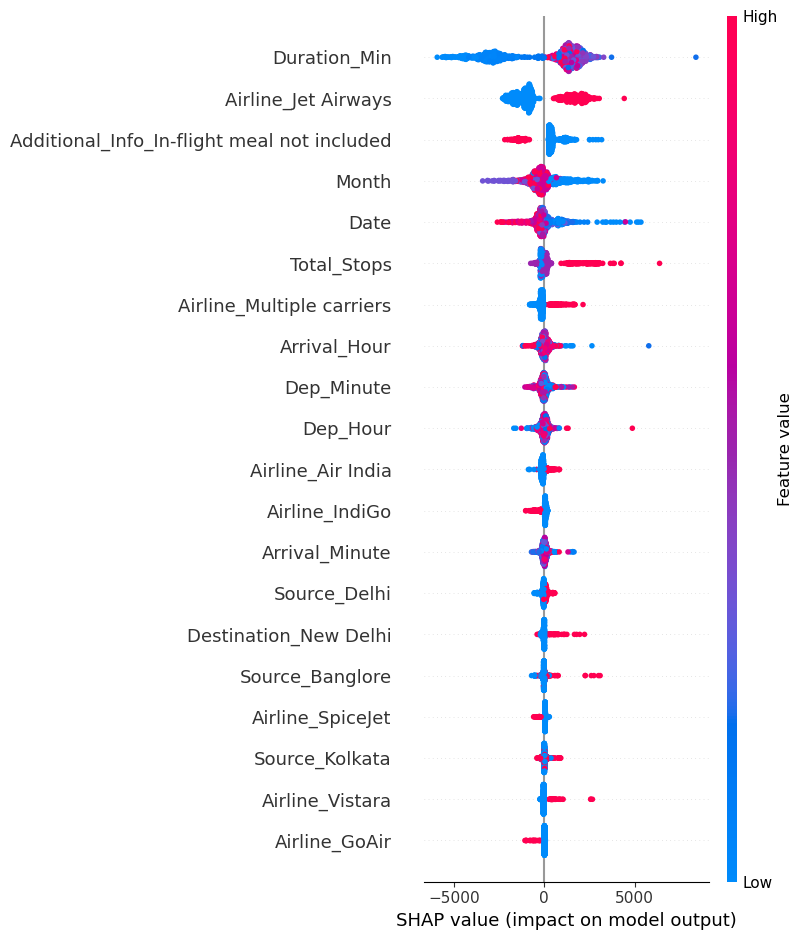

In [108]:
# 1) Get transformed feature names (after preprocessor)
preprocessor.fit(X_train)   # ensure fitted to get OHE categories
def get_feature_names(ct, numeric_cols, cat_cols):
    names = []
    for name, trans, cols in ct.transformers_:
        if name == 'remainder':
            continue
        if hasattr(trans, 'named_steps') and 'onehot' in trans.named_steps:
            ohe = trans.named_steps['onehot']
            try:
                fnames = list(ohe.get_feature_names_out(cols))
            except Exception:
                fnames = list(ohe.get_feature_names(cols))
            names.extend(fnames)
        else:
            names.extend(list(cols))
    return names

feature_names = get_feature_names(preprocessor, numeric_cols, cat_cols)

# 2) Feature importances (XGBoost)
model_step = best_xgb.named_steps['model']   # actual XGBRegressor
fi = pd.Series(model_step.feature_importances_, index=feature_names).sort_values(ascending=False)
print("Top 20 XGBoost importances:")
display(fi.head(20))

# 3) SHAP for deeper explanations (optional, slower)
import shap
explainer = shap.TreeExplainer(model_step)   # uses the fitted booster
# Create the preprocessed train matrix to feed into shap
X_train_trans = preprocessor.transform(X_train)
# For large datasets, sample a subset for SHAP
sample_idx = np.random.choice(X_train_trans.shape[0], size=min(1000, X_train_trans.shape[0]), replace=False)
shap_vals = explainer.shap_values(X_train_trans[sample_idx])
plt.figure(figsize=(4,3))
# Summary plot (requires an interactive environment)
shap.summary_plot(shap_vals, features=X_train_trans[sample_idx], feature_names=feature_names, show=True)



In [ ]:
out_model_path = "xgb_model.joblib"
joblib.dump(best_xgb, out_model_path, compress=3)
print("Saved XGBoost pipeline to:", out_model_path)

# Save metadata
meta = {
    "model": "XGBRegressor",
    "params": rs.best_params_,
    "metrics_test": {"rmse": float(best_rmse), "mae": float(best_mae), "r2": float(best_r2)},
    "train_rows": int(X_train.shape[0]),
    "feature_count": len(feature_names),
    "numeric_cols": numeric_cols,
    "cat_cols": cat_cols
}
with open("xgb_metadata.json", "w") as f:
    json.dump(meta, f, indent=2)
print("Saved metadata to xgb_metadata.json")


Saved XGBoost pipeline to: xgb_model.joblib
Saved metadata to xgb_metadata.json
